<a href="https://colab.research.google.com/github/andrefsc/SDC_M04/blob/main/M06_Tarea_Individual_P1_AndreCastanho.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Master en Intelig√™ncia Artificial en el Deporte, Edici√≥n 8**

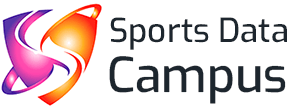

__Tarea Individual M√≥dulo 6 - Parte 1__
````
An√°lisis de sentimiento con BERT : Reviews de Pel√≠culas

La primera parte de esta tarea consiste en utilizar el modelo BERT para realizar un an√°lisis de sentimiento de reviews de pel√≠culas.

Utilizaremos el notebook Tarea_Modulo_6_Parte_1.ipynb c√≥mo plantilla, donde se necesitan completar varias celdas del notebook con
el c√≥digo necesario para realizar las tareas que se piden (Instrucciones al principio del notebook).
Adem√°s, se deben contestar un par de preguntas sobre el desarrollo al final del notebook.

Se utiliza un tokenizador preentrenado del modelo 'distilbert-base-uncased-finetuned-sst-2-english'.

---

Andr√© Silveira Castanho
April, 2024

`````

**Explicaci√≥n del C√≥digo**

````
Este c√≥digo permite acceder a los archivos almacenados en Google Drive desde un cuaderno de Colab, montando el Google Drive
como un sistema de archivos en la ruta especificada (/content/drive).

````

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


El ambiente virtual de Google Colab ya incluye muchas de las bibliotecas com√∫nmente usadas en tareas de inteligencia artificial.
No obstante, es necesario a√±adir la biblioteca **transformers** de Huggingface y **tqdm**, que facilita la visualizaci√≥n de barras de progreso en bucles for.

In [2]:
!pip install transformers
!pip install tqdm

# 0. Imports

En la secci√≥n **Imports** agrupamos todas las librer√≠as y clases que debemos importar en esta tarea.

In [3]:
# import basic libraries for data science
import pandas as pd # para manipulaci√≥n y an√°lisis de datos
import numpy as np # para operaciones matem√°ticas de alto nivel
import matplotlib.pyplot as plt # para la visualizaci√≥n de datos

# import torch and transformers
import torch # el framework principal para operaciones con tensores y redes neuronales
from torch import cuda # de PyTorch, para operaciones en GPUs
from torch.utils.data import Dataset, DataLoader # para manejar y cargar datos en formato adecuado para entrenar modelos con PyTorch
from transformers import AutoModelForSequenceClassification, AutoTokenizer # de la biblioteca transformers, para cargar modelos preentrenados
                                                                           # y tokenizadores que se ajustan autom√°ticamente al modelo

# import different metrics for evaluation
# Para evaluar el rendimiento de modelos de clasificaci√≥n
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report
from sklearn.metrics import classification_report, accuracy_score, f1_score

# import tqdm to track progress
# para mostrar barras de progreso en bucles, facilitando el seguimiento de largas ejecuciones
from tqdm import tqdm
from tqdm.notebook import tqdm

# import some python modules required for some of the utility functions
import itertools # ofrece construcciones eficientes de bucles
import re # para operaciones de expresiones regulares
import os # para interactuar con el sistema operativo, como manejo de archivos y directorios

# 1. Functions Utils

En la secci√≥n **Functions Utils** se encuentran varias funciones de utilidad con sus docstrings que se utilizar√°n a largo de la implementaci√≥n para preprocesar y limpiar datos y tambi√©n evaluar los resultados.

**1.1. Text Processing and Cleaning Functions**

**Funci√≥n: encode_sentiment**

````
Funci√≥n que codifica etiquetas de sentimiento textual a formato num√©rico.
Esto es √∫til para convertir datos categ√≥ricos de texto en formatos num√©ricos que pueden ser procesados por algoritmos de aprendizaje autom√°tico.

````

In [4]:
def encode_sentiment(sentiment):
  """
  Label encode sentiment.

  Parameters
  ----------
  sentiment: str, sentiment {"positive", "sentiment"}

  Returns
  -------
  int, 1's for positive and 0's for negative

  """
  if sentiment == "positive":
    return 1
  else:
    return 0

**Funci√≥n: is_ascii**

````
Funci√≥n que determina si un car√°cter es de tipo ASCII.
Recibe como par√°metro w, que es un car√°cter en forma de cadena de texto.
Retorna True si el car√°cter puede ser codificado en ASCII, y False si no puede, lo cual indicar√≠a que el car√°cter incluye s√≠mbolos o letras especiales que no est√°n incluidos en la tabla ASCII est√°ndar.
Este tipo de funci√≥n es √∫til para filtrar o validar textos que deben cumplir con ciertos est√°ndares de codificaci√≥n.
````

In [5]:
def is_ascii(w):
  """
  Check if character is ascii type.

  Parameters
  ----------
  w: str, character

  Returns
  -------
  bool, True if character is ascii. False otherwise.
  """
  try:
    w.encode("ascii")
    return True
  except UnicodeEncodeError:
    return False

**Funci√≥n: text_cleaning**
````
Funci√≥n que utiliza para limpiar un texto de s√≠mbolos, puntuaci√≥n y otros elementos no deseados, facilitando su procesamiento posterior en tareas de an√°lisis de texto. La funci√≥n text_cleaning realiza las siguientes operaciones sobre el texto que recibe como par√°metro text:

1. Eliminar formatos de cadena como saltos de l√≠nea (\n) y tabulaciones (\t),reemplaz√°ndolos por un punto y espacio para mantener la separaci√≥n de las sentencias.
2. Excluir palabras con caracteres no-ASCII, es decir, filtrar palabras que contengan caracteres especiales o acentuados que no se encuentren en la codificaci√≥n ASCII est√°ndar.
3. Eliminar direcciones de correo electr√≥nico que comienzan con "@", y URLs completas que comiencen con "http" o "www".
4. Remover puntuaci√≥n, manteniendo √∫nicamente puntos y comas para no alterar el fin de las sentencias ni los elementos decimales, y convertir todo el texto a min√∫sculas para homogeneizar la capitalizaci√≥n.

El resultado es un texto limpio (cleaned_text) que solamente contiene palabras en letras min√∫sculas y caracteres ASCII, con puntos y comas como √∫nica puntuaci√≥n, lo cual simplifica an√°lisis posteriores como la tokenizaci√≥n o el modelado de lenguaje natural.
````


In [6]:
def text_cleaning(text):
  """
  Clean text from symbols, punctuation, etc.

  Parameters
  ----------
  text: string, text data

  Returns
  -------
  cleaned_text: string, cleaned text data
  """
  # remove string formatting '\n' or '\t'
  tmp_text = re.sub(r'\n+', '. ', text)
  tmp_text = re.sub(r'\t+', '. ', text)
  # remove words with non-ascii characters
  tmp_text = " ".join([word for word in tmp_text.split() if is_ascii(word)])
  # remove email address
  tmp_text = " ".join([word for word in tmp_text.split() if not word.startswith("@")])
  # remove urls
  tmp_text = re.sub(r'http\S+', '', tmp_text, flags=re.MULTILINE)
  tmp_text = re.sub(r'www\S+', '', tmp_text, flags=re.MULTILINE)
  # remove punctuation but . (to split sentences)
  cleaned_text = re.sub('[^A-Za-z.,]+', ' ', tmp_text)
  # lowercase
  cleaned_text = cleaned_text.lower()

  return cleaned_text

**1.2. Evaluation Functions**

**Funci√≥n: plot_confusion_matrix**

````
Funci√≥n que permite visualizar la matriz de confusi√≥n de un modelo de clasificaci√≥n, que ayuda a evaluar su precisi√≥n.
Puede normalizar la matriz para comparar proporciones y utiliza un mapa de colores para representar los valores.
Los elementos de la matriz se anotan con valores num√©ricos, ajustando el color del texto para mejorar la legibilidad seg√∫n el fondo.

Nota:
interpolation='nearest': Este argumento especifica el m√©todo de interpolaci√≥n para renderizar la imagen.
La opci√≥n 'nearest' utiliza el valor del p√≠xel m√°s cercano para colorear cada p√≠xel visualizado, lo que ayuda a mantener
la fidelidad de los valores originales sin suavizarlos. Esto es ideal para visualizar claramente cada valor de la matriz sin efectos de interpolaci√≥n entre p√≠xeles.

````

In [7]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=15)
    plt.xlabel('Predicted label',fontsize=15)

# 2. Settings

En la secci√≥n **Settings** definimos variables y objetos que utilizaremos en el desarrollo y queremos tener agrupados en el mismo lugar.

**Definici√≥n de Variables Clave:**

````
MAX_LEN = 512: Establece el n√∫mero m√°ximo de tokens a 512 para los textos que se procesar√°n, lo cual es importante para definir la longitud de entrada que el modelo puede manejar.
BATCH_SIZE = 64: Define el tama√±o del lote para el entrenamiento del modelo, lo que afecta directamente la memoria que se consumir√° y la velocidad de entrenamiento.
SEED = 42: Fija una semilla para el generador de n√∫meros aleatorios para garantizar resultados reproducibles.

````

In [8]:
# Defining some key variables that will be used later on
MAX_LEN = 512 # max number of tokens
BATCH_SIZE = 64
SEED = 42 # for reprodudible results

**Inicializaci√≥n del Tokenizador:**

````
Carga un tokenizador preentrenado del modelo 'distilbert-base-uncased-finetuned-sst-2-english', que es √∫til para convertir texto
en tokens que el modelo de Transformers puede procesar`
````

In [9]:
# Initialiaze model tokenizer
TOKENIZER = AutoTokenizer.from_pretrained('distilbert-base-uncased-finetuned-sst-2-english')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

**Configuraci√≥n del Dispositivo:**

````
Determina si se utilizar√° una GPU (con CUDA) o una CPU para el entrenamiento, dependiendo de la disponibilidad.
Esto es crucial para la eficiencia en el entrenamiento, ya que las GPUs permiten una computaci√≥n m√°s r√°pida.

````

In [10]:
# Setting up the device for GPU usage if available
DEVICE = 'cuda' if cuda.is_available() else 'cpu'
print(DEVICE)

cuda


# 3. Data

En la secci√≥n **Data** necesitamos cargar los datos en un dataframe de pandas, codificar el sentimiento y limpiar el texto.

Podeis hacer uso de las funciones de utilidad **encode_sentiment()** y **text_cleaning()**.

**Explicaci√≥n del C√≥digo**

````
Este c√≥digo carga un conjunto de datos desde un archivo CSV ubicado en un directorio espec√≠fico de Google Drive.

Luego aplica una funci√≥n de codificaci√≥n a la columna 'sentiment' de los datos cargados. La funci√≥n encode_sentiment se utiliza
para convertir los valores textuales de la columna 'sentiment' en valores num√©ricos, espec√≠ficamente transformando los
sentimientos "positive" en 1 y cualquier otro sentimiento en 0. Esta codificaci√≥n es √∫til para procesos de an√°lisis de
datos y modelos de aprendizaje autom√°tico que requieren entradas num√©ricas.

Cargar Datos: Se leen los datos del archivo CSV utilizando pd.read_csv() de la biblioteca Pandas y se almacenan en el DataFrame raw_data.

Codificar Sentimientos: Se modifica la columna 'sentiment' del DataFrame aplicando la funci√≥n encode_sentiment a cada elemento.
Esto convierte los sentimientos textuales en valores binarios num√©ricos, facilitando su uso en an√°lisis estad√≠sticos y modelos predictivos.

````

In [11]:
### 1. Escribir c√≥digo para cargar los datos y codificar la columna sentiment.###

# Carregar os dados do arquivo CSV no diret√≥rio de GoogleDrive
file_path = '/content/drive/MyDrive/Colab_notebooks/Files/01_dataset.csv'
raw_data = pd.read_csv(file_path)

# Aplicar a fun√ß√£o de codifica√ß√£o na coluna 'sentiment'
raw_data['sentiment'] = raw_data['sentiment'].apply(encode_sentiment)

**Explicaci√≥n del C√≥digo**

````
El m√©todo raw_data.info(), se emplea para obtener un resumen conciso del DataFrame raw_data.
Este m√©todo es extremadamente √∫til para obtener informaci√≥n fundamental sobre la estructura y las caracter√≠sticas del DataFrame,
especialmente antes de proceder con an√°lisis m√°s detallados o la limpieza de datos.

````

In [12]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 781.4+ KB


**Explicaci√≥n del C√≥digo**

````
El m√©todo raw_data.head(10), se emplea para visualizar las primeras 10 filas del DataFrame raw_data.
Se pretende obtener una r√°pida visi√≥n general de los datos, especialmente para verificar la estructura inicial del DataFrame,
los tipos de datos y las primeras entradas.

````

In [13]:
raw_data.head(10)

review  sentiment
0  One of the other reviewers has mentioned that ...          1
1  A wonderful little production. <br /><br />The...          1
2  I thought this was a wonderful way to spend ti...          1
3  Basically there's a family where a little boy ...          0
4  Petter Mattei's "Love in the Time of Money" is...          1
5  Probably my all-time favorite movie, a story o...          1
6  I sure would like to see a resurrection of a u...          1
7  This show was an amazing, fresh & innovative i...          0
8  Encouraged by the positive comments about this...          0
9  If you like original gut wrenching laughter yo...          1

**Explicaci√≥n del C√≥digo**

````
Para contar cu√°ntos sentimientos son representados por 0 (negativos) y cu√°ntos por 1 (positivos) en un DataFrame de pandas,
se utiliza el m√©todo value_counts() aplicado a la columna correspondiente, que en tu caso es 'sentiment'.

````

In [15]:
df = pd.DataFrame(raw_data)

# Aplicando value_counts() na coluna 'sentiment'
sentiment_counts = df['sentiment'].value_counts()

# Imprimindo o resultado
print(sentiment_counts)

sentiment
1    25000
0    25000
Name: count, dtype: int64


**Explicaci√≥n del C√≥digo**

````
Copia un DataFrame, limpia la columna 'review' usando la funci√≥n text_cleaning() para eliminar caracteres indeseados
y normalizar el texto, y muestra las primeras 10 filas del resultado para verificar la limpieza aplicada.

````

In [17]:
### 2. Escribir c√≥digo para limpiar el texto utilizando la funci√≥n text_cleaning() ###

# Crear una copia del DataFrame original para aplicar la limpieza
cleaned_data = raw_data.copy()

# Aplicar la funci√≥n 'text_cleaning' en la columna 'review'
cleaned_data["review"] = cleaned_data["review"].apply(text_cleaning)

cleaned_data.head(10)

review  sentiment
0  one of the other reviewers has mentioned that ...          1
1  a wonderful little production. br br the filmi...          1
2  i thought this was a wonderful way to spend ti...          1
3  basically there s a family where a little boy ...          0
4  petter mattei s love in the time of money is a...          1
5  probably my all time favorite movie, a story o...          1
6  i sure would like to see a resurrection of a u...          1
7  this show was an amazing, fresh innovative ide...          0
8  encouraged by the positive comments about this...          0
9  if you like original gut wrenching laughter yo...          1

**Explicaci√≥n del C√≥digo**

````
Genera y muestra un resumen estad√≠stico de la columna 'sentiment' del DataFrame cleaned_data, incluyendo conteo, media,
desviaci√≥n est√°ndar, m√≠nimos, m√°ximos y percentiles. Esta informaci√≥n ayuda a entender la distribuci√≥n de los datos de polaridad.
````

In [18]:
# Descripci√≥n estad√≠stica de la polaridad (sentiment)
print(cleaned_data['sentiment'].describe())

count    50000.000000
mean         0.500000
std          0.500005
min          0.000000
25%          0.000000
50%          0.500000
75%          1.000000
max          1.000000
Name: sentiment, dtype: float64


**Explicaci√≥n del C√≥digo**

````
Se genera un gr√°fico de barras que representa la distribuci√≥n de frecuencias de los diferentes sentimientos
en la columna 'sentiment' del DataFrame cleaned_data.
````

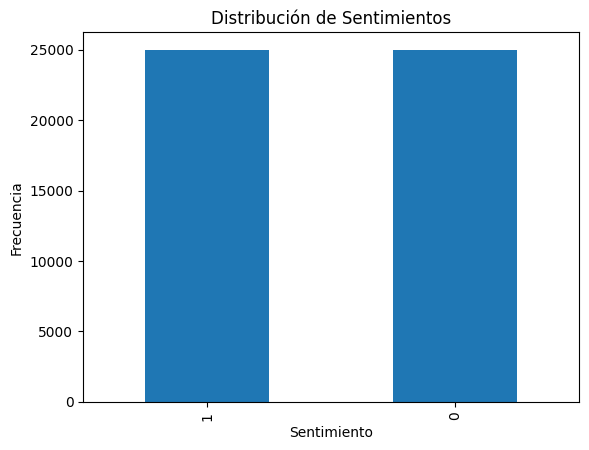

In [19]:
# Distribuci√≥n de sentimientos
cleaned_data['sentiment'].value_counts().plot(kind='bar')
plt.title('Distribuci√≥n de Sentimientos')
plt.xlabel('Sentimiento')
plt.ylabel('Frecuencia')
plt.show()


**Explicaci√≥n del C√≥digo**

````
Se utiliza las librer√≠as matplotlib.pyplot y WordCloud para generar y visualizar una nube de palabras a partir de las rese√±as contenidas
en la columna review del DataFrame cleaned_data.
Primero, concatena todos los textos de esta columna en una sola cadena.
Luego, crea una nube de palabras que visualiza la frecuencia de cada t√©rmino.  
La visualizaci√≥n resultante muestra claramente cu√°les t√©rminos son m√°s comunes en las rese√±as, ayudando a identificar r√°pidamente
los temas m√°s destacados discutidos por los usuarios.
````

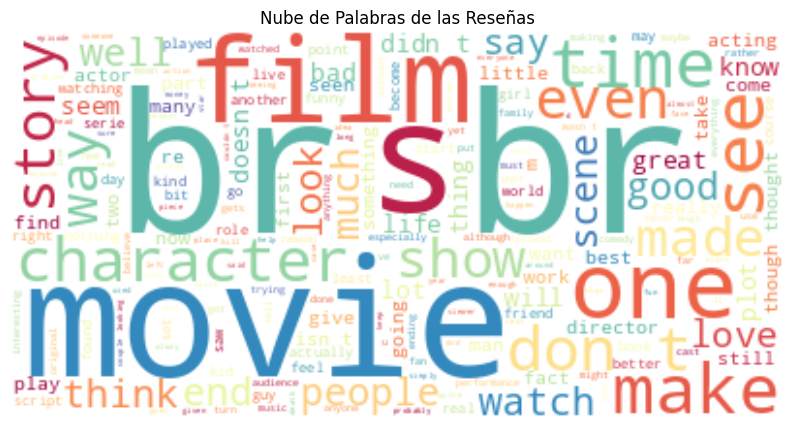

In [21]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Generaci√≥n de la nube de palabras
text = ' '.join(review for review in cleaned_data['review'])  # Utilizando la columna correcta
word_cloud = WordCloud(colormap='Spectral', max_font_size=100, background_color='white').generate(text)

# Visualizaci√≥n de la nube de palabras
plt.figure(figsize=(10,7))
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de Palabras de las Rese√±as')
plt.show()

**Explicaci√≥n del C√≥digo**

````
Aqui se utiliza la biblioteca TextBlob para analizar el sentimiento de las rese√±as en el DataFrame cleaned_data.
Define y aplica una funci√≥n, detailed_sentiment, que clasifica cada rese√±a en categor√≠as de sentimiento desde "Muy positivo" a "Muy negativo" basado en la polaridad calculada.
Esta funci√≥n se aplica a las 5000 rese√±as y los resultados se visualizan en un gr√°fico de barras, mostrando la distribuci√≥n de estos sentimientos detallados.
Esto permite una evaluaci√≥n r√°pida y visual del tono general de las rese√±as en el conjunto de datos.

````

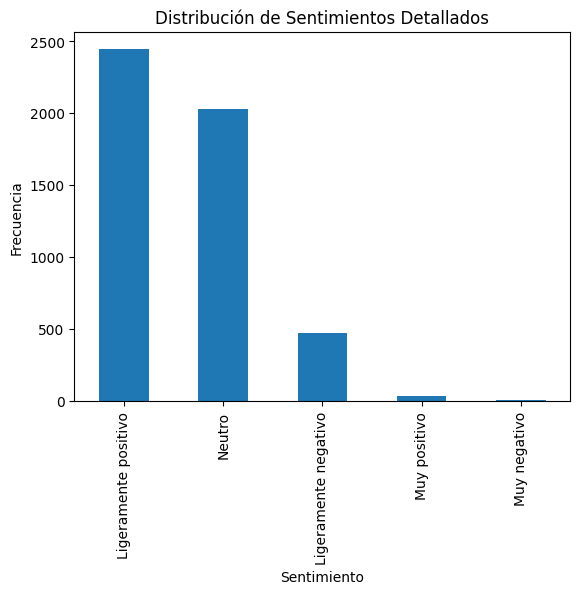

In [23]:
from textblob import TextBlob

def detailed_sentiment(text):
    polarity = TextBlob(text).sentiment.polarity
    if polarity > 0.5:
        return 'Muy positivo'
    elif polarity > 0.1:
        return 'Ligeramente positivo'
    elif polarity > -0.1:
        return 'Neutro'
    elif polarity > -0.5:
        return 'Ligeramente negativo'
    else:
        return 'Muy negativo'

cleaned_data['detailed_sentiment'] = cleaned_data['review'][:5000].apply(detailed_sentiment)
cleaned_data['detailed_sentiment'].value_counts().plot(kind='bar')
plt.title('Distribuci√≥n de Sentimientos Detallados')
plt.xlabel('Sentimiento')
plt.ylabel('Frecuencia')
plt.show()

**Explicaci√≥n del C√≥digo**

````
Se utiliza t√©cnicas de procesamiento de texto para analizar rese√±as mediante CountVectorizer y Latent Dirichlet Allocation (LDA) de la librer√≠a sklearn.
Primero, convierte las rese√±as a una matriz num√©rica de t√©rminos-frecuencia, ignorando las palabras m√°s comunes y ajustando la matriz por frecuencias de aparici√≥n.
Luego, aplica LDA para identificar cinco t√≥picos principales en los textos, y visualiza las palabras clave de cada t√≥pico, facilitando la comprensi√≥n de los temas predominantes en las rese√±as.
El objetivo es descubrir y presentar los temas recurrentes para su an√°lisis y toma de decisiones basadas en datos.
````

In [24]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Vectorizaci√≥n de texto
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=1000, stop_words='english')
tf = tf_vectorizer.fit_transform(cleaned_data['review'])

# LDA
lda = LatentDirichletAllocation(n_components=5, random_state=0)
lda.fit(tf)

def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_name = " ".join(top_words[:2])  # las 2 palabras m√°s frecuentes para nombrar el t√≥pico
        print(f"T√≥pico '{topic_name}':")
        print(" ".join(top_words))

display_topics(lda, tf_vectorizer.get_feature_names_out(), 10)

T√≥pico 'movie film':
movie film like just good really movies don time bad
T√≥pico 'movie like':
movie like great good love funny just comedy old little
T√≥pico 'film movie':
film movie just like horror bad plot br good really
T√≥pico 'br movie':
br movie like just good really don time film bad
T√≥pico 'film br':
film br story life films time man character best great


**Explicaci√≥n del C√≥digo**

````
Aqui se a√±ade dos nuevas columnas al DataFrame cleaned_data: sentence_length y word_length, que contienen, respectivamente, la longitud de las sentencias en palabras y la longitud promedio de las palabras de cada rese√±a.
Para visualizar la distribuci√≥n de estas m√©tricas, se generan dos histogramas con curvas de estimaci√≥n de densidad de kernel (KDE), uno para la longitud de las sentencias y otro para la longitud de las palabras, utilizando la funci√≥n sns.histplot de Seaborn.
El objetivo principal de este c√≥digo es explorar la estructura textual de las rese√±as, proporcionando una visi√≥n general sobre la complejidad y diversidad del texto analizado, lo cual puede ser √∫til para tareas como la optimizaci√≥n de modelos de procesamiento de lenguaje natural o para mejoras en sistemas de an√°lisis de texto.
````

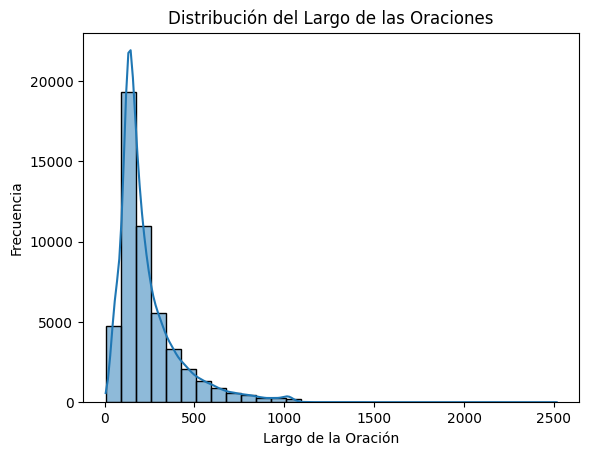

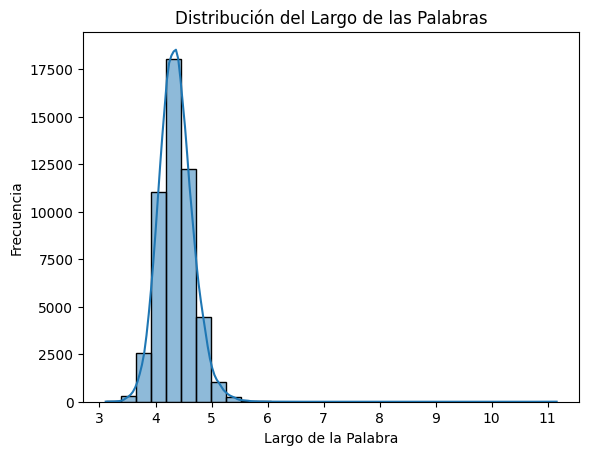

In [27]:
import seaborn as sns

cleaned_data['sentence_length'] = cleaned_data['review'].apply(lambda x: len(x.split()))
cleaned_data['word_length'] = cleaned_data['review'].apply(lambda x: np.mean([len(word) for word in x.split()]))

sns.histplot(cleaned_data['sentence_length'], bins=30, kde=True)
plt.title('Distribuci√≥n del Largo de las Oraciones')
plt.xlabel('Largo de la Oraci√≥n')
plt.ylabel('Frecuencia')
plt.show()

sns.histplot(cleaned_data['word_length'], bins=30, kde=True)
plt.title('Distribuci√≥n del Largo de las Palabras')
plt.xlabel('Largo de la Palabra')
plt.ylabel('Frecuencia')
plt.show()

**Explicaci√≥n del C√≥digo**

````
Se utiliza la biblioteca spaCy para procesar datos de texto y extraer informaci√≥n ling√º√≠stica espec√≠fica de rese√±as almacenadas en un DataFrame.
Inicialmente, carga un modelo de lenguaje en ingl√©s y define una funci√≥n count_pos para contar y devolver las 50 palabras m√°s comunes que corresponden a categor√≠as gramaticales espec√≠ficas (verbos, adjetivos y sustantivos) y que no son palabras vac√≠as.
Utiliza esta funci√≥n para analizar tres conjuntos de datos: el total de rese√±as, las rese√±as positivas y las rese√±as negativas, identificando los verbos, adjetivos y sustantivos m√°s frecuentes en cada contexto.
Para ello, selecciona una muestra aleatoria de 100 rese√±as del DataFrame, garantizando la reproducibilidad con un estado aleatorio fijo.
Finalmente, imprime las listas de las palabras m√°s comunes encontradas en cada an√°lisis.
````

In [28]:
import spacy
from collections import Counter
from spacy.lang.en.examples import sentences

# Cargar el modelo de lenguaje
nlp = spacy.load("en_core_web_sm")

# Funci√≥n para contar palabras por categor√≠a gramatical que tengan m√°s de una letra
def count_pos(reviews, pos_list):
    pos_counts = Counter()
    for doc in nlp.pipe(reviews):
        pos_counts.update([token.lemma_ for token in doc if token.pos_ in pos_list and len(token.lemma_) > 1 and not token.is_stop and token.is_alpha])
    return pos_counts.most_common(50)

# Seleccionar una muestra aleatoria de 100 registros del DataFrame
sampled_data = cleaned_data.sample(n=100, random_state=42)  # 'random_state' para reproducibilidad

# Extraer los 50 verbos m√°s usados en las rese√±as de la muestra, asegurando que cada verbo tenga m√°s de una letra
verbs = count_pos(sampled_data['review'], ['VERB'])
print("Los 50 verbos m√°s comunes:", verbs)

# Extraer los 50 adjetivos y sustantivos m√°s usados en las rese√±as positivas de la muestra
adjs_nouns_positive = count_pos(sampled_data[sampled_data['sentiment'] == 1]['review'], ['ADJ', 'NOUN'])
print("Los 50 adjetivos y sustantivos m√°s comunes en evaluaciones positivas:", adjs_nouns_positive)

# Extraer los 50 adjetivos y sustantivos m√°s usados en las rese√±as negativas de la muestra
adjs_nouns_negative = count_pos(sampled_data[sampled_data['sentiment'] == 0]['review'], ['ADJ', 'NOUN'])
print("Los 50 adjetivos y sustantivos m√°s comunes en evaluaciones negativas:", adjs_nouns_negative)

Los 50 verbos m√°s comunes: [('watch', 46), ('know', 44), ('see', 44), ('think', 42), ('go', 40), ('get', 38), ('look', 37), ('play', 36), ('come', 35), ('find', 32), ('try', 29), ('feel', 27), ('want', 27), ('like', 25), ('let', 22), ('take', 21), ('give', 21), ('make', 21), ('tell', 20), ('show', 19), ('leave', 18), ('don', 18), ('love', 18), ('start', 17), ('work', 17), ('involve', 17), ('run', 16), ('turn', 15), ('save', 14), ('say', 14), ('call', 14), ('cry', 14), ('doesn', 13), ('act', 13), ('happen', 12), ('suppose', 12), ('read', 12), ('live', 12), ('write', 12), ('end', 11), ('enjoy', 11), ('talk', 11), ('believe', 11), ('lead', 11), ('bring', 11), ('recommend', 10), ('laugh', 10), ('consider', 10), ('fall', 10), ('wonder', 10)]
Los 50 adjetivos y sustantivos m√°s comunes en evaluaciones positivas: [('film', 123), ('movie', 67), ('good', 49), ('character', 44), ('time', 32), ('story', 32), ('great', 26), ('man', 24), ('people', 20), ('life', 17), ('scene', 17), ('bit', 17), ('

# 4. Dataset and Dataloader

En la secci√≥n **Dataset and Dataloader** vamos a crear un dataset de Pytorch del tipo map-iterable que utilizaremos para almacenar los datos y procesarlos de acuerdo a los requirimientos del modelo.

Despu√©s creamos un objeto **DataLoader** de Pytorch que toma el dataset para poder pasar ejemplos al modelo en lotes o batches.

---

__Clase DistilBertDataset__

La clase **DistilBertDataset** toma como argumentos un dataframe con los datos, el tokenizador del modelo y el n√∫mero de m√°ximo de tokens que definimos en la secci√≥n **Config**.

El m√©todo **__getitem__()** toma como par√°metro un √≠ndice de los datos en el dataset, extrae el ejemplo correspondiente del dataframe y utiliza la funci√≥n **encode_plus()** del tokenizador para procesar los inputs de acuerdo a los requerimientos de DistilBERT ( special tokens [CLS] y [SEP], truncation, padding, etc.). Este m√©todo devuelve un diccionario de python con los tensores que continen los inputs ids, los attention masks y el sentimiento codificado.

El m√©todo **__len__()** simplemente devuelve el n√∫mero de ejemplos en el dataset.

---

__DataLoader__

El **DataLoader** viene a ser un generador que devulve lotes de tama√±o `BATCH_SIZE` para alimentar el modelo.

En sus par√°metros podemos definir el tama√±o de lote o batch size, si seleccionar de forma aleatoria los ejemplos a incluir en el batch o no (recomendable al realizar un entrenamiento) y tambi√©n el n√∫mero de workers a utilizar (2 para Google Colab).

---

In [29]:
class DistilBertDataset(Dataset):
    """Custom pytorch map-iterable dataset for sentiment analysis with DistilBERT."""

    def __init__(self, dataframe, tokenizer, max_len):
        # Initialize the dataset with the input dataframe, tokenizer, and maximum token length
        self.len = len(dataframe)  # Stores the number of rows in the dataframe
        self.data = dataframe  # Stores the dataframe passed as a parameter
        self.tokenizer = tokenizer  # Stores the tokenizer passed as a parameter
        self.max_len = max_len  # Stores the maximum length of tokenization allowed

    def __getitem__(self, index):
        # Return a tokenized and tensor-converted item from the dataset by index
        text = str(self.data['review'].loc[index])  # Extract the text of the review at the specified index
        text = " ".join(text.split())  # Remove extra spaces from the text
        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,  # Adds special tokens for BERT (CLS, SEP)
            max_length=self.max_len,  # Sets the maximum length for tokenization
            padding='max_length',  # Adds padding to reach `max_len` if the text is shorter
            return_token_type_ids=False,  # Does not return token type IDs (DistilBERT does not use them)
            truncation=True  # Truncates the text if it exceeds the maximum length allowed
        )
        ids = inputs['input_ids']  # Token IDs
        mask = inputs['attention_mask']  # Attention mask where `1` indicates real tokens and `0` indicates padding

        return {
            'ids': torch.tensor(ids, dtype=torch.long),  # Converts token IDs to PyTorch tensors
            'mask': torch.tensor(mask, dtype=torch.long),  # Converts the attention mask to a tensor
            'targets': torch.tensor(self.data['sentiment'].loc[index], dtype=torch.long)  # Converts the sentiment to a tensor
        }

    def __len__(self):
        # Returns the number of items in the dataset
        return self.len  # Returns the length stored during initialization


**Explicaci√≥n del C√≥digo**

````
Se inicializa una instancia de DistilBertDataset utilizando datos preprocesados, un tokenizador y una longitud m√°xima
de tokens definida. Se emplea cleaned_data como el DataFrame que contiene los textos ya limpios y normalizados.
El TOKENIZER utilizado es espec√≠fico para DistilBERT, preparando los textos adecuadamente para este modelo.

La longitud m√°xima de tokens, MAX_LEN, asegura que todos los inputs tengan el mismo tama√±o, aplicando truncamiento o padding
seg√∫n sea necesario. Este objeto dataset es ahora adecuado para usar en entrenamientos de modelos o evaluaciones,
manteniendo la consistencia y la calidad de los datos para el procesamiento de lenguaje natural con DistilBERT.
````

In [30]:
### 3. Escribir c√≥digo para crear un objeto DistilBertDataset con los inputs ###
### limpios, el tokenizador del modelo y el m√°ximo n√∫mero de tokens ###

# Crea una instancia de DistilBertDataset con los datos limpios, el tokenizador y el n√∫mero m√°ximo de tokens
dataset = DistilBertDataset(dataframe=cleaned_data, tokenizer=TOKENIZER, max_len=MAX_LEN)

**Explicaci√≥n del C√≥digo**

````
Imprime informaci√≥n sobre el sexto elemento del conjunto de datos dataset. Muestra los IDs de entrada, las m√°scaras
de atenci√≥n y el objetivo (sentimiento) para ese elemento en particular. Esto permite una r√°pida verificaci√≥n de c√≥mo est√°n
estructurados y almacenados los datos en el conjunto de datos personalizado para el an√°lisis de sentimientos con DistilBERT.
````

In [31]:
print("---- Visually inspecting 5th element ----")
print("\n")
print(f"Input ids: {dataset[4]['ids']}")
print("\n")
print(f"Attention masks: {dataset[4]['mask']}")
print("\n")
print(f"Target: {dataset[4]['targets']}")
print("------------------------------------------")

---- Visually inspecting 5th element ----


Input ids: tensor([  101,  9004,  3334,  4717,  7416,  1055,  2293,  1999,  1996,  2051,
         1997,  2769,  2003,  1037, 17453, 14726,  2143,  2000,  3422,  1012,
         2720,  1012,  4717,  7416,  4107,  2149,  1037, 14954,  6533,  2055,
         2529,  4262,  1012,  2023,  2003,  1037,  3185,  2008,  3849,  2000,
         2022,  4129,  2149,  2054,  2769,  1010,  2373,  1998,  3112,  2079,
         2000,  2111,  1999,  1996,  2367,  8146,  2057,  8087,  1012,  7987,
         7987,  2023,  2108,  1037,  8386,  2006,  1996,  4300,  8040,  7295,
         8838,  3917,  1055,  2377,  2055,  1996,  2168,  4323,  1010,  1996,
         2472, 15210,  1996,  2895,  2000,  1996,  2556,  2051,  2047,  2259,
         2073,  2035,  2122,  2367,  3494,  3113,  1998,  7532,  1012,  2169,
         2028,  2003,  4198,  1999,  2028,  2126,  1010,  2030,  2178,  2000,
         1996,  2279,  2711,  1010,  2021,  2053,  2028,  3849,  2000,  2113,
         

**Explicaci√≥n del C√≥digo**

````
Establece los par√°metros para el DataLoader, que se utiliza para cargar datos en lotes durante el entrenamiento
de un modelo de aprendizaje autom√°tico.

Se definen tres par√°metros principales: el tama√±o del lote (batch_size), si se deben mezclar los datos (shuffle),
y el n√∫mero de subprocesos (num_workers) que se utilizar√°n para cargar los datos en paralelo.

Luego, se crea el DataLoader usando estos par√°metros junto con el conjunto de datos previamente creado dataset.
Esto facilita la carga eficiente y escalable de datos para el entrenamiento del modelo.
````

In [32]:
# define dataloader params
dataloader_params = {'batch_size': BATCH_SIZE,
                'shuffle': False,
                'num_workers': 2
                }

# create dataloader
data_loader = DataLoader(dataset, **dataloader_params)

# 5. Model

En la secci√≥n **Model** creamos la **clase DistilBERTClass()** con el modelo ya ajustado que se encuentra en el hub de modelos de Huggingface.

El m√©todo **forward()** de la clase toma los inputs ids y attention mask que devuelve el m√©todo **__getitem__()** de la clase **DistilBertDataset**.


````
Se define una clase personalizada en PyTorch llamada DistilBERTClass para un modelo de clasificaci√≥n de secuencias
utilizando DistilBERT pre-entrenado. En el m√©todo __init__, se carga el modelo DistilBERT pre-entrenado utilizando
la biblioteca Hugging Face Transformers. En el m√©todo forward, se pasan los IDs de entrada y la m√°scara de atenci√≥n al modelo,
y las salidas del modelo son las probabilidades de clasificaci√≥n para cada clase en la tarea de clasificaci√≥n de secuencias.
Este modelo puede ser utilizado para realizar tareas de clasificaci√≥n de texto de manera eficiente, aprovechando el poder
del modelo DistilBERT pre-entrenado
````

In [33]:
class DistilBERTClass(torch.nn.Module):
  """Custom class for DilstilBERT model for Sequence Classification."""

  def __init__(self):
      super(DistilBERTClass, self).__init__()
      # Inicializa el modelo DistilBERT pre-entrenado para clasificaci√≥n de secuencias
      self.model = AutoModelForSequenceClassification \
        .from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

  def forward(self, input_ids, attention_mask):
      # Pasa los IDs de entrada y la m√°scara de atenci√≥n al modelo
      output = self.model(input_ids=input_ids, attention_mask=attention_mask)
      # Extrae las predicciones del modelo
      logits = output.logits

      return logits

# 6. Inference

En la secci√≥n **Inference** vamos a utilizar el modelo para realizar inferencia y obtener los sentimientos de las reviews.

Despu√©s utilizamos la funci√≥n **inference()** para obtener las predicciones.


**Explicaci√≥n del C√≥digo**

````
Se descarga y carga un modelo DistilBERT pre-entrenado utilizando la clase DistilBERTClass,
y luego mueve el modelo a la GPU si est√° disponible (DEVICE).

Se presenta una representaci√≥n de la arquitectura del modelo DistilBERT para clasificaci√≥n de secuencias,
presentada en formato de √°rbol, mostrando las capas y subcapas del modelo.

> DistilBERTClass: Es la clase definida que envuelve al modelo DistilBERT.
> DistilBertForSequenceClassification: Es la arquitectura espec√≠fica de DistilBERT utilizada para tareas de clasificaci√≥n de secuencias.
> distilbert: Representa la parte principal del modelo, que incluye la capa de embeddings, el transformador y las capas de clasificaci√≥n.
> embeddings: Contiene las capas de embeddings, como embeddings de palabras y embeddings de posici√≥n.
> transformer: Es la parte del modelo que ejecuta la transformaci√≥n de los embeddings.
> layer: Contiene las capas del transformador, cada una consistiendo en un bloque de transformador.
> attention: Representa la capa de atenci√≥n multi-cabeza dentro de cada bloque de transformador.
> sa_layer_norm: Capa de normalizaci√≥n despu√©s de la atenci√≥n.
> ffn: Capa de feedforward dentro de cada bloque de transformador.
> pre_classifier: Capa lineal antes de la capa de clasificaci√≥n final.
> classifier: Capa lineal de clasificaci√≥n final.
> dropout: Capa de dropout utilizada para regularizaci√≥n.
````

In [34]:
# Download and load trained DistilBERT model
model = DistilBERTClass()
model.to(DEVICE)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

DistilBERTClass(
  (model): DistilBertForSequenceClassification(
    (distilbert): DistilBertModel(
      (embeddings): Embeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer): Transformer(
        (layer): ModuleList(
          (0-5): 6 x TransformerBlock(
            (attention): MultiHeadSelfAttention(
              (dropout): Dropout(p=0.1, inplace=False)
              (q_lin): Linear(in_features=768, out_features=768, bias=True)
              (k_lin): Linear(in_features=768, out_features=768, bias=True)
              (v_lin): Linear(in_features=768, out_features=768, bias=True)
              (out_lin): Linear(in_features=768, out_features=768, bias=True)
            )
            (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            

**Explicaci√≥n del C√≥digo**

````
Define una funci√≥n llamada inference que realiza la inferencia (predicci√≥n) utilizando un modelo DistilBERT para clasificaci√≥n binaria.
El modelo se coloca en modo de evaluaci√≥n y luego se itera sobre los lotes de datos de entrada.
Para cada lote, se env√≠an los IDs de entrada y la m√°scara de atenci√≥n al dispositivo de computaci√≥n (CPU o GPU), y se obtienen las predicciones del modelo.
Los resultados y los objetivos se almacenan en listas y se devuelven al final de la funci√≥n.
````

In [35]:
def inference(data_loader, model, device):
    """
    Clasificaci√≥n binaria utilizando el modelo DistilBERT.

    Par√°metros
    ----------
    data_loader: objeto DataLoader de Pytorch
    model: Objeto DistilBERTClass
    device: str, dispositivo

    Devoluciones
    -------
    listas, logits de las salidas y objetivos
    """
    # poner el modelo en modo de evaluaci√≥n
    model.eval()
    # crear listas para ser pobladas con predicciones y objetivos correspondientes
    fin_targets = []
    fin_outputs = []
    # no calcular gradientes ya que no son necesarios para inferencia
    with torch.no_grad():
        # iterar sobre lotes y obtener predicciones
        for bi, d in tqdm(enumerate(data_loader), total=len(data_loader)):
            ids = d['ids']
            mask = d['mask']
            targets = d['targets']

            # enviarlos al dispositivo cuda que estamos usando
            ids = ids.to(device, dtype=torch.long)
            mask = mask.to(device, dtype=torch.long)
            targets = targets.to(device, dtype=torch.long)
            # obtener los logits de las salidas
            outputs = model(
                input_ids=ids,
                attention_mask=mask
            )
            # Normalizar logits y almacenar resultados y objetivos en listas
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())

    return fin_outputs, fin_targets


**Explicaci√≥n del C√≥digo**

````
Se realiza la inferencia para an√°lisis de sentimiento.
Utiliza la funci√≥n inference para obtener las salidas (predicciones) y los objetivos (etiquetas reales) del modelo
para un conjunto de datos de entrada, utilizando un DataLoader y un modelo previamente definidos.

Los resultados de la inferencia se almacenan en las variables outputs y targets.
````

In [36]:
# run inference -> sentiment analysis

# Realiza la inferencia en los datos de entrada utilizando la funci√≥n 'inference'
# Se espera que 'inference' devuelva las salidas (predicciones) y los objetivos (etiquetas reales) del modelo

outputs, targets = inference(
    data_loader=data_loader,  # DataLoader que contiene los datos de entrada
    model=model,              # Modelo utilizado para la inferencia
    device=DEVICE             # Dispositivo en el que se realizar√° la inferencia (CPU o GPU)
)


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


  0%|          | 0/782 [00:00<?, ?it/s]

**Explicaci√≥n del C√≥digo**

````
Aqui se procesa y visualiza los resultados de una inferencia de modelo en PyTorch.
Inicialmente, transforma los outputs y targets, que son tensores de PyTorch, en arrays de NumPy.
Esta conversi√≥n es necesaria para facilitar la manipulaci√≥n y visualizaci√≥n de los datos, y se realiza verificando si el c√°lculo se efectu√≥ en una CPU o GPU; en caso de haberse usado GPU, los datos se transfieren primero al CPU.
Luego, el script imprime los primeros cinco outputs y sus targets correspondientes.
Este paso es crucial para verificar r√°pidamente la precisi√≥n de las inferencias del modelo, permitiendo observar de forma inmediata si los resultados son los esperados seg√∫n los valores reales.
````

In [37]:
# Suponiendo que 'outputs' y 'targets' sean listas, necesitas convertirlos a tensores de PyTorch.
outputs = torch.tensor(outputs, device='cuda')  # crear el tensor en la GPU
targets = torch.tensor(targets, device='cuda')  # crear el tensor en la GPU

# Verificar si el dispositivo predeterminado debe ser CUDA y si los tensores est√°n en la GPU
if torch.cuda.is_available() and DEVICE == 'cuda':
    outputs = outputs.cpu().numpy()  # Mueve el tensor a la CPU y luego convierte a array de NumPy
    targets = targets.cpu().numpy()  # Mueve el tensor a la CPU y luego convierte a array de NumPy
else:
    outputs = outputs.numpy()  # Convierte directamente a array de NumPy si ya est√° en la CPU
    targets = targets.numpy()  # Convierte directamente a array de NumPy si ya est√° en la CPU

# Imprimir las primeras 5 l√≠neas de 'outputs' y 'targets' para verificar los resultados
print("Primeros 5 outputs:")
for i in range(5):
    print(f"Output {i+1}: {outputs[i]}")

print("\nPrimeros 5 targets (valores reales esperados):")
for i in range(5):
    print(f"Target {i+1}: {targets[i]}")

Primeros 5 outputs:
Output 1: [0.78473234 0.25906625]
Output 2: [0.03092587 0.97576797]
Output 3: [0.02827958 0.97626036]
Output 4: [0.9842179  0.03259172]
Output 5: [0.04347434 0.96239936]

Primeros 5 targets (valores reales esperados):
Target 1: 1
Target 2: 1
Target 3: 1
Target 4: 0
Target 5: 1


**Explicaci√≥n del C√≥digo**

````
Utiliza np.argmax() para obtener las predicciones a partir de las logits normalizadas.
La funci√≥n np.argmax() devuelve el √≠ndice del valor m√°ximo a lo largo del eje especificado.
En este caso, especificamos axis=1 para obtener el √≠ndice de la clase m√°s probable para cada ejemplo..
````

In [38]:
### 4. Escribir c√≥digo obtener las predicci√≥nes a partir de las logits normalizadas ###
### Criterio: Elegir la clase m√°s probable ###
### La funci√≥n de numpy np.argmax() puede ser de gran ayuda ;) ###
### Sustituir None por el c√≥digo necesario ###

predicted_classes = np.argmax(outputs, axis=1)

### Imprimir las clases predichas para verificar los resultados
print("Clases predichas para los primeros 5 ejemplos:")
for i in range(5):
    print(f"Ejemplo {i+1}: Clase predicha = {predicted_classes[i]}")

Clases predichas para los primeros 5 ejemplos:
Ejemplo 1: Clase predicha = 0
Ejemplo 2: Clase predicha = 1
Ejemplo 3: Clase predicha = 1
Ejemplo 4: Clase predicha = 0
Ejemplo 5: Clase predicha = 1


# 7. Evaluation

En la secci√≥n **Evaluation** calculamos m√©tricas t√≠picas de un poblema de clasificaci√≥n binario: Accuracy y F1 Score.

Tambi√©n graficamos la matriz de confusi√≥n utlizando la funci√≥n de utilidad **plot_confusion_matrix()**.

Finalmente, hacemos una peque√±a evaluaci√≥n visual de los inputs, los targets y las predicciones.

**Explicaci√≥n del C√≥digo**

````
Se calcula y presenta diversas m√©tricas para evaluar el rendimiento de un modelo de clasificaci√≥n binaria, usando los valores reales (targets) y las predicciones (predicted_classes).
Calcula la precisi√≥n (accuracy), la puntuaci√≥n F1 (f_score), precisi√≥n y recall individuales, y genera una matriz de confusi√≥n.
Estas m√©tricas son cruciales para entender cu√°n bien el modelo predice las clases correctas, balanceando entre la exactitud de las predicciones positivas (precisi√≥n) y la proporci√≥n de positivos reales correctamente identificados (recall).
La matriz de confusi√≥n proporciona una vista detallada del rendimiento del modelo al mostrar los verdaderos y falsos positivos y negativos.
````

In [39]:
### 5. Calcular accuracy y f1_score ###

# Calcula la precisi√≥n (accuracy) y la puntuaci√≥n F1 (f_score) utilizando los valores reales (targets) y las clases predichas (predicted_classes).
# Utiliza accuracy_score() para calcular la precisi√≥n y f1_score() para calcular la puntuaci√≥n F1.

accuracy = accuracy_score(targets, predicted_classes)
f_score = f1_score(targets, predicted_classes)

# Calculando precis√£o, recall y matriz de confusi√≥n
precision = precision_score(targets, predicted_classes, average='binary')
recall = recall_score(targets, predicted_classes, average='binary')
conf_mat = confusion_matrix(targets, predicted_classes)

print(f"Precisi√≥n del entrenamiento = {accuracy}")
print(f"Puntuaci√≥n F1 del entrenamiento = {f_score}")
print("\n")
print(f"Precisi√≥n individual del entrenamiento = {precision}")
print(f"Recall del entrenamiento = {recall}")
print("\n")
print("Matriz de Confusi√≥n del entrenamiento:")
print(conf_mat)


Precisi√≥n del entrenamiento = 0.88854
Puntuaci√≥n F1 del entrenamiento = 0.885024034989994


Precisi√≥n individual del entrenamiento = 0.9138511354437391
Recall del entrenamiento = 0.85796


Matriz de Confusi√≥n del entrenamiento:
[[22978  2022]
 [ 3551 21449]]


**Explicaci√≥n del C√≥digo**

````
Se genera un informe de clasificaci√≥n utilizando las etiquetas reales (targets) y las clases predichas (predicted_classes).
Utiliza la funci√≥n classification_report() de la biblioteca scikit-learn para calcular y mostrar m√©tricas como precisi√≥n, recall, puntuaci√≥n F1 y soporte para cada clase (en este caso, "Negative" y "Positive").
El informe proporciona una evaluaci√≥n detallada del rendimiento del modelo para cada clase en los datos de prueba.
````

In [40]:
# classification report
print(classification_report(targets, predicted_classes, target_names=["Negative", "Positive"]))

              precision    recall  f1-score   support

    Negative       0.87      0.92      0.89     25000
    Positive       0.91      0.86      0.89     25000

    accuracy                           0.89     50000
   macro avg       0.89      0.89      0.89     50000
weighted avg       0.89      0.89      0.89     50000



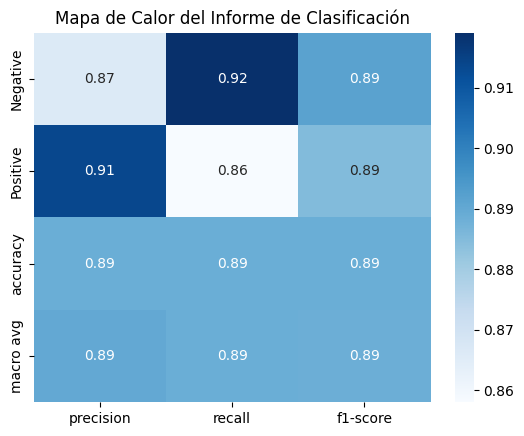

In [41]:
report = classification_report(targets, predicted_classes, target_names=["Negative", "Positive"], output_dict=True)
df = pd.DataFrame(report).transpose()
sns.heatmap(df.iloc[:-1, :].drop(columns="support"), annot=True, cmap="Blues", fmt=".2f")
plt.title("Mapa de Calor del Informe de Clasificaci√≥n")
plt.show()

**Explicaci√≥n del C√≥digo**

````
Se calcula y muestra la matriz de confusi√≥n, que es una representaci√≥n visual de las predicciones del modelo en comparaci√≥n con las etiquetas reales.
Utiliza las funciones confusion_matrix() y plot_confusion_matrix() para generar y mostrar la matriz respectivamente.
La matriz se normaliza para resaltar las proporciones y mejorar la interpretaci√≥n.
````

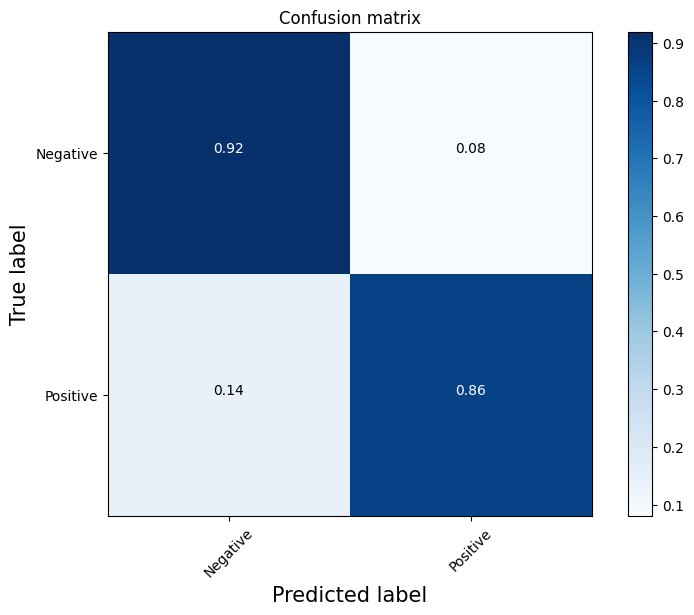

In [42]:
# print the confusion matrix
cnf_matrix = confusion_matrix(targets, predicted_classes, labels=[0, 1])
plt.figure(figsize=(8,6))
plot_confusion_matrix(
    cnf_matrix,classes=['Negative','Positive'],
    normalize=True,
    title='Confusion matrix'
)

**Comentario a los Resultados**

````
Cada classe tem 25,000 exemplos, indicando um conjunto de teste perfeitamente balanceado.

A propor√ß√£o de previs√µes corretas (tanto positivas quanto negativas) √© de 89%.

Os resultados indicam que o modelo est√° performando bem, com um bom equil√≠brio entre precis√£o e recall.

A performance √© sim√©trica entre as classes, o que √© ideal em cen√°rios onde cada classe √© igualmente importante.

O modelo n√£o mostra uma tend√™ncia significativa de favorecer uma classe em detrimento da outra, o que pode ser comum em conjuntos de dados desbalanceados.
````

**Explicaci√≥n del C√≥digo**

````
En final, se realiza una evaluaci√≥n visual mostrando una muestra de las primeras 20 revisiones limpiadas junto con sus etiquetas reales y las salidas del modelo.
Utiliza un bucle for para iterar sobre las revisiones, las etiquetas reales (targets) y las salidas del modelo (outputs).
Para cada iteraci√≥n, imprime el texto de la revisi√≥n, su etiqueta real y la salida predicha por el modelo.
Esto proporciona una forma r√°pida de inspeccionar visualmente c√≥mo el modelo est√° clasificando las revisiones en comparaci√≥n con las etiquetas reales.
````

In [43]:
#visual evalution
for review, target, output in zip(cleaned_data.review.values[:20], targets, predicted_classes):
  print(f"Text: {review}")
  print(f"Target: {target}\tOutput: {output}\n")

Text: one of the other reviewers has mentioned that after watching just oz episode you ll be hooked. they are right, as this is exactly what happened with me. br br the first thing that struck me about oz was its brutality and unflinching scenes of violence, which set in right from the word go. trust me, this is not a show for the faint hearted or timid. this show pulls no punches with regards to drugs, sex or violence. its is hardcore, in the classic use of the word. br br it is called oz as that is the nickname given to the oswald maximum security state penitentary. it focuses mainly on emerald city, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. em city is home to many..aryans, muslims, gangstas, latinos, christians, italians, irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away. br br i would say the main appeal of the show is due to the fact that it g

# 8. Preguntas

8.1. La funci√≥n **text_cleaning** se utiliza para limpiar el texto de caracteres, puntuaci√≥n, etc. que a√±aden ruido a los datos y dificultan el aprendizaje. ¬øCu√°l crees que ha sido el proceso para identificar los requerimientos de limpieza de los datos y que se ven reflejados es esta funci√≥n?
¬øCrees que se podr√≠a mejorar esta funci√≥n?

**< Respuesta >**

**¬øCu√°l crees que ha sido el proceso para identificar los requerimientos de limpieza de los datos y que se ven reflejados es esta funci√≥n?**

La funci√≥n text_cleaning se utiliza para limpiar el texto de caracteres, puntuaciones y otros elementos que a√±aden ruido a los datos, lo que complica el proceso de aprendizaje autom√°tico. Esta limpieza es esencial para preparar los datos para an√°lisis y modelado efectivos, especialmente en aplicaciones de procesamiento de lenguaje natural (NLP).

La funci√≥n realiza diversas operaciones espec√≠ficas sobre el texto que recibe como par√°metro: Elimina formatos de cadena como los saltos de l√≠nea (\n) y tabulaciones (\t), sustituy√©ndolos por un punto y un espacio. Esta modificaci√≥n ayuda a mantener la separaci√≥n de las sentencias, facilitando la lectura y el an√°lisis sint√°ctico posterior del texto. Tambi√©n excluye palabras con caracteres no-ASCII, es decir, filtra palabras que contienen caracteres especiales o acentuados que no se encuentran en la codificaci√≥n ASCII est√°ndar, simplificando as√≠ la codificaci√≥n del texto y evitando errores en fases posteriores de an√°lisis que pueden no manejar bien estos caracteres.

Adem√°s, elimina direcciones de correo electr√≥nico que comienzan con "@", y URLs completas que empiezan con "http" o "www" para concentrar el an√°lisis en el contenido textual relevante y no en enlaces o referencias externas. Remueve toda puntuaci√≥n, excepto puntos y comas, para no alterar el fin de las sentencias ni los elementos decimales, y convierte todo el texto a min√∫sculas para homogeneizar la capitalizaci√≥n y reducir la complejidad del espacio de caracter√≠sticas con el que trabajar√° el modelo de NLP.

El resultado es un texto limpio (cleaned_text) que solamente contiene palabras en letras min√∫sculas y caracteres ASCII, con puntos y comas como √∫nica puntuaci√≥n, lo cual simplifica an√°lisis posteriores como la tokenizaci√≥n o el modelado de lenguaje natural.

Asi...

Se presupone que el proceso comenz√≥ con un an√°lisis exploratorio detallado, incluyendo una inspecci√≥n visual exhaustiva de muestras representativas de los textos. Esta etapa ser√≠a fundamental para detectar inicialmente las inconsistencias m√°s comunes, tales como espacios extras, caracteres especiales y errores de codificaci√≥n que suelen estar presentes en los datos brutos.

Adem√°s, es probable que se llevara a cabo un estudio de la frecuencia de caracteres y palabras para identificar y registrar aquellos elementos que, siendo recurrentes, no aportan valor significativo al an√°lisis; esto incluir√≠a stopwords, puntuaciones innecesarias y etiquetas HTML.

En esta fase, se habr√≠a contemplado c√≥mo adaptar la limpieza para mejorar la tokenizaci√≥n y otros procesos de NLP subsiguientes. Se tomar√≠an decisiones basadas en la forma en que los modelos de NLP gestionan diferentes tokens y estructuras textuales, incluyendo la decisi√≥n de mantener o eliminar ciertas puntuaciones.

Asimismo, es plausible que se considerara la conversi√≥n de todo el texto a min√∫sculas para reducir la variabilidad del texto y facilitar la uniformidad, dado que muchos modelos de NLP no distinguen entre may√∫sculas y min√∫sculas.

Con los criterios preliminares de limpieza establecidos, se iniciar√≠an ciclos de pruebas y validaci√≥n, donde los textos limpios ser√≠an procesados utilizando modelos de NLP preliminares para observar el impacto de la limpieza en la calidad del an√°lisis. Este proceso permitir√≠a revelar si son necesarios ajustes adicionales en la funci√≥n de limpieza.

Este enfoque hipot√©tico, iterativo y basado en la evidencia facilitar√≠a la maximizaci√≥n de la relevancia y la precisi√≥n del texto para an√°lisis y modelado subsiguientes, minimizando elementos que podr√≠an introducir errores, ruido o distorsiones. La adaptaci√≥n continua, fundamentada en pruebas pr√°cticas y te√≥ricas, ser√≠a crucial para afinar esta herramienta indispensable en la preparaci√≥n de datos para NLP. Este proceso no solo optimizar√≠a los recursos utilizados sino que tambi√©n mejorar√≠a continuamente la calidad de los datos procesados, asegurando que la limpieza contribuya efectivamente a la utilidad y precisi√≥n de los an√°lisis de datos subsiguientes.



**¬øCrees que se podr√≠a mejorar esta funci√≥n?**

La funci√≥n text_cleaning que se est√° utilizando puede ser mejorada y extendida para manejar una mayor variedad de casos y asegurar que el texto limpio sea lo m√°s √∫til posible para an√°lisis.

Entre las mejoras sugeridas, la Normalizaci√≥n Unicode (NFC) es esencial, ya que combina caracteres y diacr√≠ticos que est√°n separados en su forma descompuesta (NFD), aumentando la consistencia de los caracteres especiales y acentos.

La Limpieza de Saltos de L√≠nea y Tabulaciones reemplaza \n y \t directamente por un punto seguido de un espacio, manteniendo la integridad de las oraciones y facilitando la segmentaci√≥n posterior en oraciones.

Tambi√©n se podera mejorar la Eliminaci√≥n de URLs y Correos Electr√≥nicos con expresiones regulares m√°s eficientes para evitar que estos elementos contaminen el conjunto de datos.

En la Filtraci√≥n de Caracteres No ASCII, en lugar de eliminar estos caracteres, se sustituyen por espacios, que ayudan a mantener la integridad y el formato del texto.

La Limpieza de Puntuaci√≥n se ajusta para mantener solo palabras, espacios y puntos finales, lo que preserva la estructura de las oraciones mientras elimina puntuaciones innecesarias que pueden interferir con los modelos de NLP.

La conversi√≥n a min√∫sculas y la eliminaci√≥n de espacios extras preparan el texto para un an√°lisis m√°s consistente, convirtiendo todo el texto a min√∫sculas y eliminando espacios redundantes.

Entre las Sugerencias Adicionales, la extensi√≥n de limpieza para Emojis y Contracciones puede incluir expresiones regulares para eliminar emojis o expandir contracciones (por ejemplo, cambiar "can't" por "cannot"), especialmente si estas caracter√≠sticas son significativas para el modelo o an√°lisis.

La Integraci√≥n de Stopwords implica la eliminaci√≥n de palabras que no contribuyen con contenido sem√°ntico significativo, y el Stemming o Lematizaci√≥n opcional puede aplicarse para reducir las palabras a sus formas base, facilitando la estandarizaci√≥n y reducci√≥n de variabilidad en el texto.

Uno de los m√°s criticos y identificados es la expresi√≥n 'br' que se resolver√° con la implementaci√≥n de una expresi√≥n regular re.sub(r'\bbr\b', '. ', texto) busca exactamente la palabra 'br' y la reemplaza por un punto y un espacio. Usamos \b alrededor de 'br' para asegurar que solo se reemplacen instancias que constituyan una palabra completa, evitando afectar palabras que contengan 'br'.

Un ejemplo de funci√≥n modificada:


In [51]:
import re
import unicodedata
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def limpieza_de_texto(texto, eliminar_stopwords=True, usar_lematizacion=True):

    # Normalizaci√≥n Unicode (NFC)
    texto = unicodedata.normalize('NFC', texto)

    # Eliminaci√≥n de elementos 'br' residuales de HTML
    texto = re.sub(r'\bbr\b', '. ', texto)

    # Sustituci√≥n de saltos de l√≠nea y tabulaciones por un punto y espacio
    texto = re.sub(r'[\t\n]+', '. ', texto)

    # Eliminaci√≥n de URLs
    texto = re.sub(r'http\S+', '', texto, flags=re.MULTILINE)
    texto = re.sub(r'www\S+', '', texto, flags=re.MULTILINE)

    # Eliminaci√≥n de emails
    texto = re.sub(r'\S*@\S*\s?', '', texto)

    # Eliminaci√≥n de caracteres no ASCII sustituyendo por espacios
    texto = re.sub(r'[^\x00-\x7F]+', ' ', texto)

    # Eliminaci√≥n de emojis
    texto = re.sub(r'[^\w\s.,]+', '', texto)

    # Eliminaci√≥n de puntuaci√≥n (excepto puntos finales)
    texto = re.sub(r'[^\w\s.]+', ' ', texto)

    # Conversi√≥n de contracciones (ejemplos)
    texto = re.sub(r"can\'t", "cannot", texto)
    texto = re.sub(r"won\'t", "will not", texto)
    texto = re.sub(r"n\'t", " not", texto)

    # Sustituci√≥n de m√∫ltiples espacios por un √∫nico espacio
    texto = re.sub(r'\s+', ' ', texto, flags=re.MULTILINE)

    # Conversi√≥n a min√∫sculas
    texto = texto.lower().strip()

    # Tokenizaci√≥n
    tokens = word_tokenize(texto)

    # Eliminaci√≥n de stopwords
    if eliminar_stopwords:
        palabras_irrelevantes = set(stopwords.words('english'))
        tokens = [palabra for palabra in tokens if palabra not in palabras_irrelevantes]

    # Lematizaci√≥n
    if usar_lematizacion:
        lematizador = WordNetLemmatizer()
        tokens = [lematizador.lemmatize(palabra) for palabra in tokens]

    # Reconstrucci√≥n del texto
    texto_limpio = ' '.join(tokens)

    return texto_limpio

# Ejemplo de texto con todas las particularidades
texto_ejemplo = "Este es un ejemplo de texto con elementos HTML residuales como 'br', as√≠ como URLs como http://www.ejemplo.com y correos electr√≥nicos como john.doe@example.com. Tambi√©n incluye contracciones como can't y emojis como üòÄ. ¬°Espero que la funci√≥n funcione bien!"

# Aplicar la limpieza de texto
texto_limpio = limpieza_de_texto(texto_ejemplo)

# Imprimir el texto limpio
print("Texto limpio:")
print(texto_limpio)


Texto limpio:
este e un ejemplo de texto con elementos html residuales como . como url como correos electr nicos como tambi n incluye contracciones como cant emojis como . espero que la funci n funcione bien


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!




---



8.2. En la plantilla, ¬øCu√°l es el prop√≥sito de la siguiente l√≠nea de c√≥digo?

**model.to(DEVICE)**

**< Respuesta >**

En PyTorch, la instrucci√≥n model.to(DEVICE) es crucial para dirigir d√≥nde se ejecutar√°n las operaciones del modelo‚Äîen la CPU o en la GPU.

La variable DEVICE se establece t√≠picamente a 'cuda' para GPUs (si est√° disponible) o 'cpu' de lo contrario, asegurando que tanto el modelo como los datos procesados est√©n en el mismo dispositivo.

DEVICE es una variable que especifica el dispositivo de c√°lculo que se utilizar√°, t√≠picamente definido como 'cuda' para GPUs Nvidia o 'cpu' si no hay GPU disponible. Esto se determina generalmente con una verificaci√≥n como torch.cuda.is_available() para decidir din√°micamente qu√© dispositivo usar basado en la disponibilidad.

En el contexto de PyTorch, un modelo puede ser creado en la memoria de la CPU por defecto. Si se pretende utilizar la GPU para acelerar los c√°lculos, el modelo debe ser expl√≠citamente movido a la GPU usando to(DEVICE).

Adem√°s del modelo, los datos (entradas al modelo) tambi√©n necesitan estar en el mismo dispositivo para el entrenamiento o la inferencia. Por lo tanto, usualmente se observar√° que los tensores de datos son tambi√©n trasladados a DEVICE en cada lote procesado

Esto es esencial para la eficiencia computacional, especialmente con modelos complejos y grandes como BERT y sus variantes.

En resumen, esta operaci√≥n garantiza que los c√°lculos se realicen en el dispositivo adecuado, optimizando el rendimiento y evitando errores de incompatibilidad de dispositivo.
